# Cargo Flows

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/VoyagesMarketDataAPI/RateTrend.ipynb) 

This example calculates the Crude Oil Tanker Freight Rates For Very Large Crude Carriers (VLCCs) From The Arabian Gulf To China

<h3>Setup</h3>

Install the Signal Ocean SDK:

In [ ]:
pip install signal-ocean

Import required libraries / APIs / packages:

In [1]:
import pandas as pd
import seaborn as sns

from signal_ocean import Connection
from signal_ocean.voyages_market_data import VoyagesMarketDataAPI

Fill in your personal SignalOcean API subscription key acquired <a href="https://apis.signalocean.com/profile" target="_blank">here</a> and open a connection:

In [2]:
signal_ocean_api_key = '' #replace with your subscription key
connection = Connection(signal_ocean_api_key)

<h3>Import Voyages Market Data API and some additional libraries</h3>

In [3]:
api = VoyagesMarketDataAPI(connection)

Get market data for a given vessel class (VLCCs)

In [ ]:
result = api.get_voyage_market_data(vessel_class_id=84, include_matched_fixture = True,
        include_labels = True)

In [5]:
## Get matched fixtures into a dataframe
fixtures = pd.DataFrame([r.matched_fixture.__dict__ for r in result])

<h3>Clean Data</h3>

Keep columns with rate info and rate type in WS (World Scale)

In [6]:
fixtures = fixtures[(~fixtures['rate'].isnull())&(fixtures['rate_type']=='WS')]

Keep columns with info on the desired itinerary: Arabian Gulf to China

In [7]:
fixtures = fixtures[(fixtures['load_name'] == 'Arabian Gulf')&(fixtures['discharge_name'] == 'China')]

Convert to datetime to use in aggregations

In [8]:
fixtures['laycan_from'] = pd.to_datetime(fixtures['laycan_from'], errors='coerce', utc=True)

<h3>Plot the rate trend per month</h3>

<AxesSubplot:xlabel='laycan_from_month', ylabel='rate'>

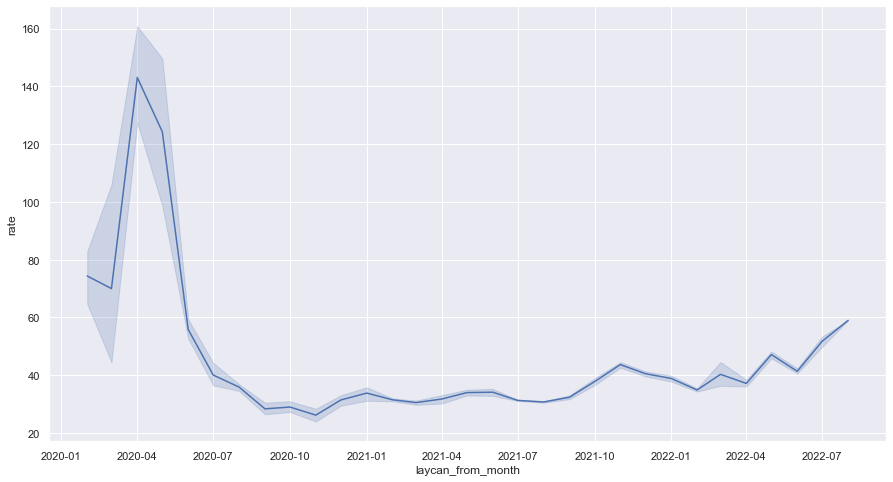

In [9]:
sns.set(rc = {'figure.figsize':(15,8)})

start_date = '2020-01-01'
fixtures['laycan_from_month'] = fixtures['laycan_from'].dt.tz_localize(None).dt.to_period('M').dt.to_timestamp()
sns.lineplot(data=fixtures[fixtures['laycan_from_month']>start_date], x='laycan_from_month', y='rate')